You can find the dataset using the extracted features [here](https://www.kaggle.com/fleanend/birds-songs-numeric-dataset).

In [1]:
import numpy as np
import matplotlib.pyplot as plt #ploting graphs
import pandas as pd # Accessing csv files 
import pickle #Storing model
from librosa import core, onset, feature, display #Extracting features from audio files
import soundfile as sf #Reading audio files
import umap #demension reduction tecnique
from IPython.display import Audio
import sklearn #SVM model
import sys #access system specific param and func

C:\Users\Bhavya\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\Users\Bhavya\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecat

In [2]:
df = pd.read_csv("./birdsong_metadata.csv")
df.head()

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/


In [3]:
print(len(set(df['genus'])))
print(len(set(df['species'])))

66
85


In [4]:
def load_audio(file_id):
    data, samplerate = sf.read("./songs/songs/xc"+str(file_id)+".flac")
    s = len(data)/samplerate
    sg = feature.melspectrogram(data, sr=samplerate, hop_length=512)
    #https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
    # Take mean amplitude M from frame with highest energy
    centerpoint = np.argmax(sg.mean(axis=0))
    M = sg[:,centerpoint].mean()
    
    # Filter out all frames with energy less than 5% of M
    mask = sg.mean(axis=0)>=M/20

    audio_mask = np.zeros(len(data), dtype=bool)
    for i in range(0,len(mask)):
        audio_mask[i*512:] = mask[i]
    return sg, mask, data, audio_mask, samplerate

In [5]:
df['length'] = np.zeros(len(df))

waves = {}


for file_id in df['file_id']:
    sg, mask, data, audio_mask, sample_rate = load_audio(file_id)
    waves[file_id] = data[audio_mask]
    df.loc[df['file_id'] == file_id,'length'] = len(data[audio_mask])
    #print(len(data[audio_mask])/sample_rate)

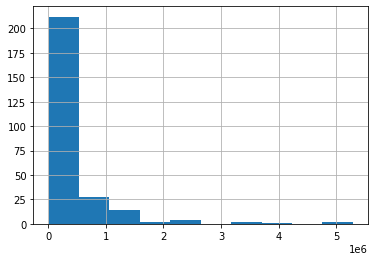

count    2.640000e+02
mean     4.307551e+05
std      6.611081e+05
min      6.144000e+03
25%      1.000960e+05
50%      2.373120e+05
75%      4.424960e+05
max      5.286262e+06
Name: length, dtype: float64

In [6]:
df['length'].hist()
plt.show()
df['length'].describe()

In [7]:
# We set window to 6.144000e+03 frames as it's the minimum length among our audio files
df['windows'] = df['length'].apply(lambda x: int(x/6.144000e+03))
df

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license,length,windows
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,256512.0,41
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,52736.0,8
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/,47104.0,7
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,152576.0,24
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,94720.0,15
...,...,...,...,...,...,...,...,...,...,...,...,...
259,132392,Turdus,philomelos,Song Thrush,david m,United Kingdom,54.1200,-0.5445,song,http://creativecommons.org/licenses/by-nc-nd/3.0/,847360.0,137
260,146756,Turdus,philomelos,Song Thrush,David Darrell-Lambert,United Kingdom,51.6608,0.0031,song,http://creativecommons.org/licenses/by-nc-sa/3.0/,251392.0,40
261,27060,Vanellus,vanellus,Northern Lapwing,Patrik berg,Sweden,58.4051,14.3028,song,http://creativecommons.org/licenses/by-nc-sa/3.0/,300032.0,48
262,97982,Vanellus,vanellus,Northern Lapwing,Herman van der Meer,Netherlands,52.1520,4.3470,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/,325632.0,53


In [8]:
# To relax the problem we'll consider the genus as the label instead of the species
# We use 23 windows per genus to have a balanced data set

n_windows = df.groupby('species')['windows'].sum().min()
n_windows

20

In [9]:
# First we create all windows for each file and partition them by species

windows = {}

for file_id in df['file_id']:
    wave = waves[file_id]
    species = df[df['file_id']==file_id]['genus'].values[0] + "_" + df[df['file_id']==file_id]['species'].values[0]
    if species not in windows:
        windows[species] = []
    for i in range(0, int(len(wave)/6.144000e+03)):
        windows[species].append(wave[i:int(i+6.144000e+03)])
        

In [10]:
# We randomly pick 20 windows for each species

# Save other samples for testing

windows_fixed = {}
windows_fixed_test = {}

for species in windows.keys():
    windows_fixed[species] = []
    windows_fixed_test[species] = []
    ws = windows[species]
    index = np.random.choice(len(ws), n_windows, replace=False)
    for i in range(0, len(ws)):
        if i in index:
            windows_fixed[species].append(ws[i])
        else:
            windows_fixed_test[species].append(ws[i])

In [11]:
# Extract Features from Window
new_dataset = pd.DataFrame()

for species in windows_fixed.keys():
    for i in range(0,n_windows):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = feature.spectral_centroid(windows_fixed[species][i])[0]
        chroma = feature.chroma_stft(windows_fixed[species][i], sample_rate)
       # https://librosa.org/doc/main/generated/librosa.feature.chroma_stft.html
        for j in range(0,13):
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        new_dataset = new_dataset.append(data_point,ignore_index=True)

new_dataset.head()

C:\Users\Bhavya\AppData\Local\Programs\Python\Python37\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


,chromogram_0_0,chromogram_0_1,chromogram_0_10,chromogram_0_11,chromogram_0_12,chromogram_0_2,chromogram_0_3,chromogram_0_4,chromogram_0_5,chromogram_0_6,...,spec_centr_12,spec_centr_2,spec_centr_3,spec_centr_4,spec_centr_5,spec_centr_6,spec_centr_7,spec_centr_8,spec_centr_9,species
0,1.000000,0.945011,0.749241,0.714737,0.704973,0.311386,0.881971,0.280575,0.519973,0.170108,...,2486.230222,2731.690852,2611.073050,2702.003239,2675.278371,2817.586465,2708.632712,2738.029229,2688.206937,flammea
1,1.000000,0.833207,0.770394,0.702116,0.655413,0.326867,0.922793,0.313101,0.493068,0.167065,...,2503.140942,2731.402739,2610.782384,2702.360650,2675.551162,2817.795119,2708.001040,2738.732679,2687.312298,flammea
2,1.000000,0.897269,0.747530,0.708578,0.671679,0.320334,0.901020,0.283132,0.506008,0.168585,...,2499.849522,2730.364909,2609.803778,2703.557248,2676.546952,2818.466355,2705.808330,2741.165516,2684.176462,flammea
3,0.996255,0.839120,0.760417,0.705142,0.662990,0.329859,0.924461,0.300951,0.493679,0.167647,...,2490.339399,2730.212868,2609.668562,2703.721296,2676.695017,2818.554952,2705.497481,2741.509330,2683.727860,flammea
4,0.859704,0.739100,0.753993,0.731847,0.680061,0.363065,0.953847,0.309297,0.484194,0.170480,...,2493.672534,2729.280167,2608.882859,2704.669440,2677.627188,2819.049396,2703.645608,2743.551931,2681.033314,flammea


In [12]:
for i in new_dataset.columns:
    print(i)

chromogram_0_0
chromogram_0_1
chromogram_0_10
chromogram_0_11
chromogram_0_12
chromogram_0_2
chromogram_0_3
chromogram_0_4
chromogram_0_5
chromogram_0_6
chromogram_0_7
chromogram_0_8
chromogram_0_9
chromogram_10_0
chromogram_10_1
chromogram_10_10
chromogram_10_11
chromogram_10_12
chromogram_10_2
chromogram_10_3
chromogram_10_4
chromogram_10_5
chromogram_10_6
chromogram_10_7
chromogram_10_8
chromogram_10_9
chromogram_11_0
chromogram_11_1
chromogram_11_10
chromogram_11_11
chromogram_11_12
chromogram_11_2
chromogram_11_3
chromogram_11_4
chromogram_11_5
chromogram_11_6
chromogram_11_7
chromogram_11_8
chromogram_11_9
chromogram_1_0
chromogram_1_1
chromogram_1_10
chromogram_1_11
chromogram_1_12
chromogram_1_2
chromogram_1_3
chromogram_1_4
chromogram_1_5
chromogram_1_6
chromogram_1_7
chromogram_1_8
chromogram_1_9
chromogram_2_0
chromogram_2_1
chromogram_2_10
chromogram_2_11
chromogram_2_12
chromogram_2_2
chromogram_2_3
chromogram_2_4
chromogram_2_5
chromogram_2_6
chromogram_2_7
chromogram_2_8

In [13]:
# Extract Features from Window for test
new_dataset_test = pd.DataFrame()

for species in windows_fixed_test.keys():
    for i in range(0,len(windows_fixed_test[species])):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = feature.spectral_centroid(windows_fixed_test[species][i])[0]
        chroma = feature.chroma_stft(windows_fixed_test[species][i], sample_rate)
        for j in range(0,13):
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        new_dataset_test = new_dataset_test.append(data_point,ignore_index=True)

new_dataset_test.head()

,chromogram_0_0,chromogram_0_1,chromogram_0_10,chromogram_0_11,chromogram_0_12,chromogram_0_2,chromogram_0_3,chromogram_0_4,chromogram_0_5,chromogram_0_6,...,spec_centr_12,spec_centr_2,spec_centr_3,spec_centr_4,spec_centr_5,spec_centr_6,spec_centr_7,spec_centr_8,spec_centr_9,species
0,0.650246,0.590960,0.712450,0.909643,0.727013,0.502476,1.000000,0.242925,0.337245,0.167843,...,2502.704267,2731.547261,2610.927066,2702.182804,2675.414141,2817.691747,2708.316600,2738.381422,2687.759667,flammea
1,0.991786,0.829836,0.769562,0.702360,0.658253,0.327552,0.923582,0.312167,0.492926,0.167125,...,2500.947926,2731.257287,2610.638982,2702.536771,2675.689443,2817.896599,2707.686043,2739.083006,2686.864803,flammea
2,0.982724,0.826884,0.768729,0.702757,0.662904,0.328242,0.924370,0.311240,0.492785,0.167188,...,2501.371357,2731.110902,2610.496832,2702.711165,2675.828996,2817.996189,2707.371617,2739.432407,2686.417165,flammea
3,0.986246,0.828101,0.767894,0.703366,0.664334,0.328939,0.925159,0.310319,0.492645,0.167255,...,2502.520325,2730.963583,2610.355902,2702.883835,2675.969849,2818.093901,2707.057774,2739.780884,2685.969370,flammea
4,1.000000,0.945205,0.744401,0.716860,0.701898,0.315170,0.885456,0.275877,0.519047,0.170131,...,2503.521703,2730.815328,2610.216159,2703.054777,2676.112022,2818.189758,2706.744518,2740.128437,2685.521405,flammea


In [14]:
# Prepare dataset to fit a simple model

features= list(new_dataset.columns)
features.remove('species')
features.remove('genus')

X = new_dataset[features].values
y = new_dataset['species'].values

X_test = new_dataset_test[features].values
y_test = new_dataset_test['species'].values

In [15]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X, y)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [16]:
sklearn.metrics.accuracy_score(y_pred=y_pred, y_true=y_test)

0.9533261157223626

In [17]:
from sklearn.naive_bayes import GaussianNB
clf_nb = GaussianNB()
clf_nb.fit(X,y)
y_pred_nb = clf_nb.predict(X_test)

In [18]:
sklearn.metrics.accuracy_score(y_pred=y_pred_nb, y_true=y_test)

0.8846385179838807

In [19]:
# The data can be used to predict, let's export the newly created datasets

new_dataset.to_csv("train.csv")
new_dataset_test.to_csv("test.csv")

In [ ]:
filename = 'svm.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
filename = 'naive.sav'
pickle.dump(clf_nb, open(filename, 'wb'))